In [1]:
from sklearn.ensemble import RandomForestClassifier
from collections import deque
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
import time


In [2]:
np.random.seed(40)

# Define the range for x1, x2, x3
x_range = (0, 10)

# Define the sequence of θ values
theta_values = [7, 8, 12, 13, 14, 9, 8, 7, 13, 12, 13, 11, 15, 16, 14]

# Total number of samples
total_samples = 75000

# Number of samples per θ value
samples_per_theta = total_samples // len(theta_values)

# Initialize an empty list to store the dataset
data = []

# Generate the dataset
for theta in theta_values:
    for _ in range(samples_per_theta):
        x1 = np.random.uniform(*x_range)
        x2 = np.random.uniform(*x_range)
        x3 = np.random.uniform(*x_range)
        label = '1' if x1 + x2 > theta else '0'
        data.append([x1, x2, x3, label])

# Create a DataFrame
df = pd.DataFrame(data, columns=['x1', 'x2', 'x3', 'label'])

In [3]:
def create_datastream(data, batch_size):
    return [data.iloc[i:i+batch_size] for i in range(0, len(data), batch_size)]

In [4]:
def train_random_forest_classifier(X, y, n_estimators=50):
    rf = RandomForestClassifier(n_estimators=n_estimators, n_jobs=-1)
    rf.fit(X, y)
    return rf

In [5]:
def adaptive_ensemble_size(C, sample, unique_label, anpha, min_num=3):
    """
    Cơ chế adaptive_esemble 
    C : Bộ phân loại yếu
    sample
    unique_label : Tập hợp nhãn trong luồng dữ liệu
    anpha : hyper parameter
    min_num : số lượng C tối thiểu 
    """
    probability_list = []
    # Tính toán xác suất dự đoán cho mỗi bộ phân loại trong C và lưu trữ kết quả
    sample_proba = [clf.predict_proba(sample)[0] for clf in C]
    
    for label in unique_label:
        li = []
        latest_proba = None
        
        for proba in sample_proba:
            # Tạo từ điển để ánh xạ nhãn với xác suất tương ứng
            probability_dict = {lbl: prob for lbl, prob in zip(C[0].classes_, proba)}
            # Lấy xác suất hiện tại cho nhãn đang xét
            current_proba = probability_dict.get(label, 0)
            
            if len(li) < min_num:
                # Nếu số lượng xác suất trong li nhỏ hơn min_num, thêm current_proba vào li
                li.append(current_proba)
            else:
                if latest_proba is None:
                    # Nếu latest_proba chưa được gán giá trị, gán giá trị của nó bằng xác suất mới nhất
                    latest_proba = probability_dict.get(label, 0)
                
                # So sánh xác suất hiện tại với xác suất mới nhất
                if abs(current_proba - latest_proba) < anpha:
                    # Nếu chênh lệch nhỏ hơn anpha, thêm current_proba vào li
                    li.append(current_proba)
                else:
                    # Nếu chênh lệch lớn hơn anpha, dừng vòng lặp
                    break
        
        # Thêm danh sách xác suất cho nhãn hiện tại vào probability_list
        probability_list.append(li)
    
    return probability_list

In [6]:
def linear_regression(x, y):
    """Tính hồi quy tuyến tính"""
    A = np.vstack([x, np.ones(len(x))]).T
    m, c = np.linalg.lstsq(A, y, rcond=None)[0]
    return m, c

def tendency_prediction(probability_list, Y, epsilon=0.01):
    """
    Thực hiện cơ chế dự đoán xu hướng
    Input:
    - probability_list: Danh sách xác suất cho mỗi mẫu
    - Y: Danh sách các lớp trong luồng dữ liệu
    - epsilon: Hệ số trọng số (mặc định là 0.01)
    Output:
    - Ps: Lớp dự đoán cho mẫu
    """
    predicted_probabilities = []
    
    for i, li in enumerate(probability_list):
        x = np.arange(1, len(li) + 1)
        y = np.array(li[::-1])  # Reverse the order of li
        slope, intercept = linear_regression(x, y)
        next_value = slope * (len(li) + 2) + intercept
        li = [next_value] + li  # Thêm giá trị dự đoán tiếp theo vào đầu danh sách
        weights = 1 - np.arange(1, len(li) + 1) * epsilon
        weighted_prob = np.dot(li, weights) / len(li)
        predicted_probabilities.append(weighted_prob)
    
    Ps = Y[np.argmax(predicted_probabilities)]
    
    return Ps


Precision: 0.8377707123198265
Recall: 0.8322176870748299
F1-Score: 0.8335963471215456
Accuracy: 0.8322176870748299


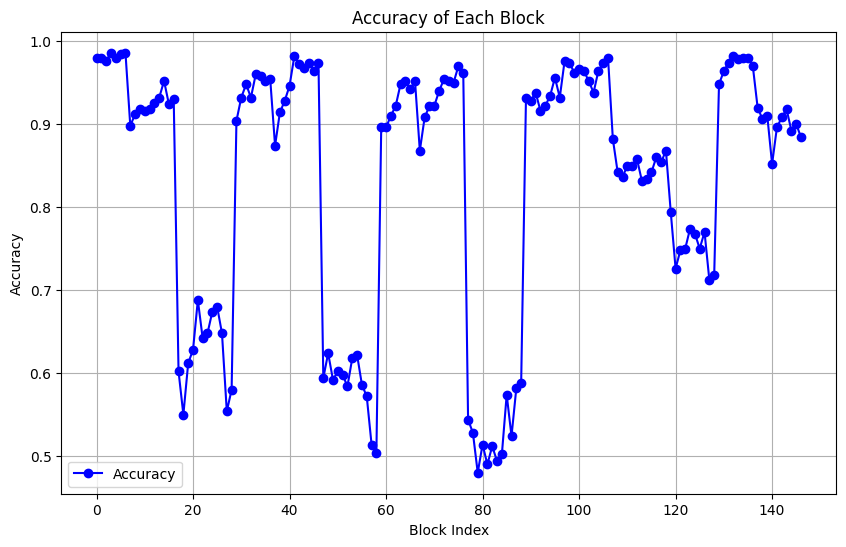

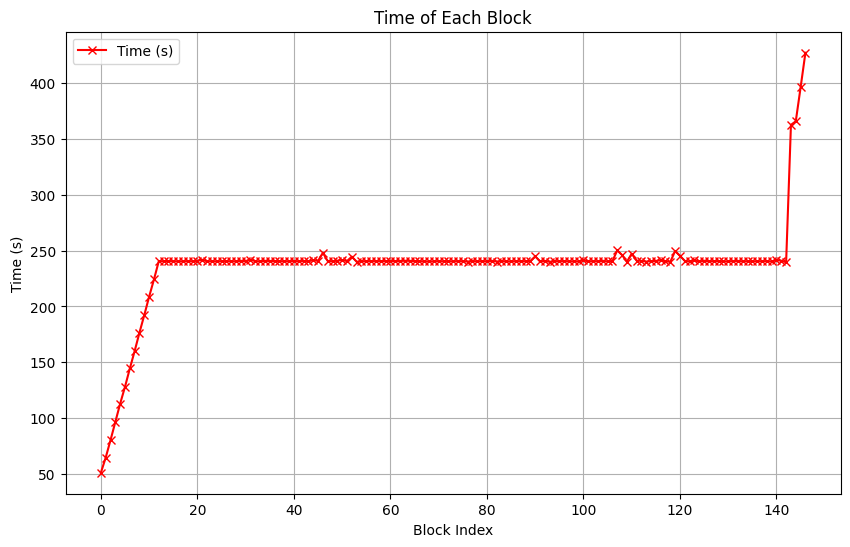

In [7]:
def process_data_stream(S, m, k, unique_labels):
    C = deque(maxlen=m)
    true_labels = []
    predicted_labels = []
    pre = []
    block_accuracies = []  # Danh sách để lưu trữ độ chính xác của từng block
    block_times = []  # Danh sách để lưu trữ thời gian xử lý của từng block

    for i in range(len(S) - 1):
        start_time = time.time()  # Bắt đầu tính thời gian cho block

        Bi = S[i]
        block_predictions = []
        X = Bi.iloc[:, :-1]
        y = Bi.iloc[:, -1]
        Ci = train_random_forest_classifier(X, y)
        C.append(Ci)
        if len(C) < k:
            continue
        Bi_1 = S[i + 1]
        for index, row in Bi_1.iterrows():
            sample = pd.DataFrame([row[:-1]], columns=Bi.columns[:-1])
            anpha = (1500 / len(Bi_1)) * 0.2
            selected_classifiers = adaptive_ensemble_size(C, sample, unique_labels, anpha)
            pre_sample = tendency_prediction(selected_classifiers, unique_labels)
            block_predictions.append(pre_sample)
            true_labels.append(row.iloc[-1])
            predicted_labels.append(pre_sample)
        pre.append(block_predictions)

        # Tính toán độ chính xác cho block hiện tại
        block_accuracy = accuracy_score(true_labels[-len(Bi_1):], predicted_labels[-len(Bi_1):])
        block_accuracies.append(block_accuracy)

        end_time = time.time()  # Kết thúc tính thời gian cho block
        elapsed_time = end_time - start_time
        block_times.append(elapsed_time)

    precision = precision_score(true_labels, predicted_labels, average='weighted')
    recall = recall_score(true_labels, predicted_labels, average='weighted')
    f1 = f1_score(true_labels, predicted_labels, average='weighted')
    accuracy = accuracy_score(true_labels, predicted_labels)
    
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-Score: {f1}")
    print(f"Accuracy: {accuracy}")

    # Trực quan hóa độ chính xác của từng block
    plt.figure(figsize=(10, 6))
    plt.plot(block_accuracies, marker='o', linestyle='-', color='b', label='Accuracy')
    plt.title('Accuracy of Each Block')
    plt.xlabel('Block Index')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Trực quan hóa thời gian của từng block
    plt.figure(figsize=(10, 6))
    plt.plot(block_times, marker='x', linestyle='-', color='r', label='Time (s)')
    plt.title('Time of Each Block')
    plt.xlabel('Block Index')
    plt.ylabel('Time (s)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Main execution
batch_size = 500
S = create_datastream(df, batch_size)
m = 15
k = 3
unique_labels = list(set(df.iloc[:, -1]))
process_data_stream(S, m, k, unique_labels)

0.6164026845637585


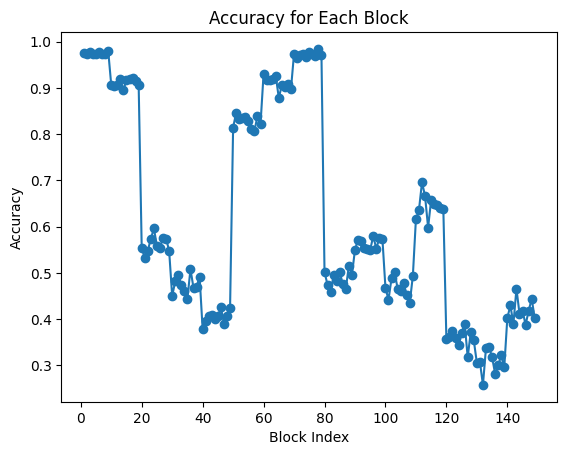

In [8]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

def train_random_forest_classifier(X, y):
    clf = RandomForestClassifier()
    clf.fit(X, y)
    return clf

def process_data_stream(S):
    """
    Processes data stream S using a Random Forest classifier.
    - S: Data stream (list of data blocks Bi)
    """
    # Use the first block as the training set
    Bi = S[0]
    X_train = Bi.iloc[:, :-1]
    y_train = Bi.iloc[:, -1]
    model = train_random_forest_classifier(X_train, y_train)

    accuracies = []

    # Predict and calculate accuracy for each subsequent block
    for i in range(1, len(S)):
        Bi_1 = S[i]
        X_test = Bi_1.iloc[:, :-1]
        y_test = Bi_1.iloc[:, -1]
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)
    average_accuracy = sum(accuracies) / len(accuracies)
    print(average_accuracy)
    # Plot the accuracies
    plt.plot(range(1, len(S)), accuracies, marker='o')
    plt.xlabel('Block Index')
    plt.ylabel('Accuracy')
    plt.title('Accuracy for Each Block')
    plt.show()

process_data_stream(S) 